In [1]:
import sys
from pathlib import Path

cwd = Path.cwd()

if (cwd / "src").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "src").exists():
    PROJECT_ROOT = cwd.parent
else:
    raise RuntimeError("Cannot find project root")

sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml


In [2]:
import pandas as pd

from src.utils import load_dataset
from src.datasets import encode_target, select_base_features
from src.features import add_irregularity_index

df = load_dataset("data/breast_cancer_wisconsin.csv")
df = encode_target(df)
df = select_base_features(df)
df = add_irregularity_index(df)

df.head()


,concavity_mean,perimeter_mean,radius_mean,area_mean,target,irregularity_index
0,0.3001,122.80,17.99,1001.0,1,0.000020
1,0.0869,132.90,20.57,1326.0,1,0.000005
2,0.1974,130.00,19.69,1203.0,1,0.000012
3,0.2414,77.58,11.42,386.1,1,0.000040
4,0.1980,135.10,20.29,1297.0,1,0.000011


In [3]:
# Define small tumore
df["size_bucket"] = pd.qcut(
    df["perimeter_mean"],
    q=3,
    labels=["Small", "Medium", "Large"]
)

df["size_bucket"].value_counts()


size_bucket
Small     190
Large     190
Medium    189
Name: count, dtype: int64

In [4]:
df_small = df[df["size_bucket"] == "Small"].copy()

print("Small tumor samples:", len(df_small))
df_small.head()


Small tumor samples: 190


,concavity_mean,perimeter_mean,radius_mean,area_mean,target,irregularity_index,size_bucket
3,0.24140,77.58,11.420,386.1,1,0.000040,Small
21,0.02956,60.34,9.504,273.9,0,0.000008,Small
31,0.12180,77.93,11.840,440.6,1,0.000020,Small
41,0.10440,71.90,10.950,371.1,1,0.000020,Small
46,0.01588,51.71,8.196,201.9,0,0.000006,Small


In [5]:
variance_summary = (
    df.groupby("size_bucket")["irregularity_index"]
    .agg(["mean", "std"])
)

variance_summary


C:\Users\sprin\AppData\Local\Temp\ipykernel_5604\1794207058.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("size_bucket")["irregularity_index"]


,mean,std
size_bucket,,
Small,0.000009,0.000013
Medium,0.000008,0.000006
Large,0.000011,0.000005


In [15]:
from pathlib import Path

FIGURES_DIR = PROJECT_ROOT / "figures"
EXPERIMENTS_DIR = PROJECT_ROOT / "experiments"

FIGURES_DIR.mkdir(exist_ok=True)
EXPERIMENTS_DIR.mkdir(exist_ok=True)

print("Figures dir:", FIGURES_DIR)
print("Experiments dir:", EXPERIMENTS_DIR)


Figures dir: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\figures
Experiments dir: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\experiments


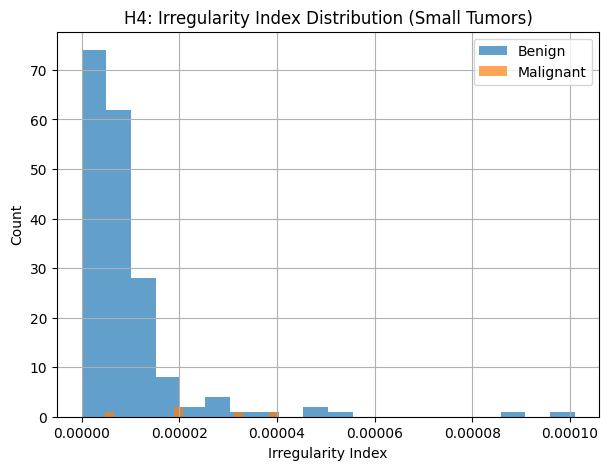

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

df_small[df_small["target"] == 0]["irregularity_index"].hist(
    bins=20, alpha=0.7, label="Benign"
)

df_small[df_small["target"] == 1]["irregularity_index"].hist(
    bins=20, alpha=0.7, label="Malignant"
)

plt.xlabel("Irregularity Index")
plt.ylabel("Count")
plt.title("H4: Irregularity Index Distribution (Small Tumors)")
plt.legend()
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h4_small_tumor_irregularity_overlap.png",
    dpi=300,
    bbox_inches="tight"
)



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from src.models import get_logistic_model

X = df_small[["irregularity_index"]]
y = df_small["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = get_logistic_model()
model.fit(X_train, y_train)

y_scores = model.predict_proba(X_test)[:, 1]
auc_small = roc_auc_score(y_test, y_scores)

auc_small


0.6071428571428572

In [10]:
df_large = df[df["size_bucket"] == "Large"]

Xl = df_large[["irregularity_index"]]
yl = df_large["target"]

Xl_tr, Xl_te, yl_tr, yl_te = train_test_split(
    Xl, yl, test_size=0.3, random_state=42, stratify=yl
)

model.fit(Xl_tr, yl_tr)
yl_scores = model.predict_proba(Xl_te)[:, 1]

roc_auc_score(yl_te, yl_scores)


0.826797385620915

In [17]:
import json

results = {
    "auc_small_tumors_irregularity": float(auc_small),
    "small_tumor_count": int(len(df_small))
}

with open(EXPERIMENTS_DIR / "h4_results.json", "w") as f:
    json.dump(results, f, indent=2)